# 🧠 Q1: Dataset Loading, Class Display

In [30]:
import os,random,cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from skimage import filters,color,data,exposure
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from collections import Counter

Classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
Num of Classes: 4


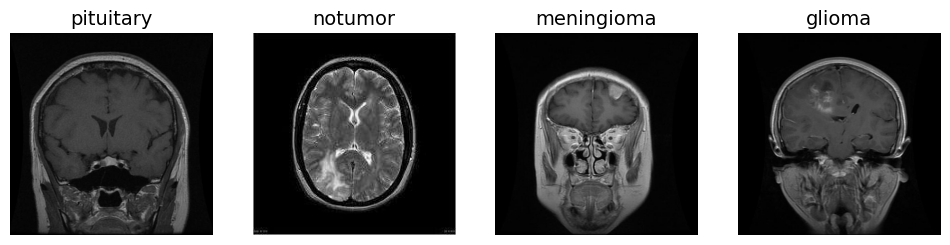

In [2]:
data='/kaggle/input/brain-tumor-mri-dataset/Training'
classes=os.listdir(data)
print("Classes:",classes)
print('Num of Classes:',len(classes))
plt.figure(figsize=(12,8))
for i,clss in enumerate(classes):
    class_path=os.path.join(data,clss)
    image_name=random.choice(os.listdir(class_path))
    image_path=os.path.join(class_path,image_name)
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.subplot(1,len(classes),i+1)
    plt.imshow(image)
    plt.title(clss,fontsize=14)
    plt.axis("off")
plt.show()

# 🔍Q2: In this task, we will:  
1. Select one image from each class of the dataset.  
2. Convert the images to grayscale (if they are in color).  
3. Compute the edge gradient angle for each pixel using Sobel filters.  
4. Construct edge histograms with 36 bins.  
5. Plot each image alongside its corresponding histogram.  
6. Select two histograms and compute their similarity measures:
   - Euclidean distance  
   - Manhattan distance  
   - Cosine distance  

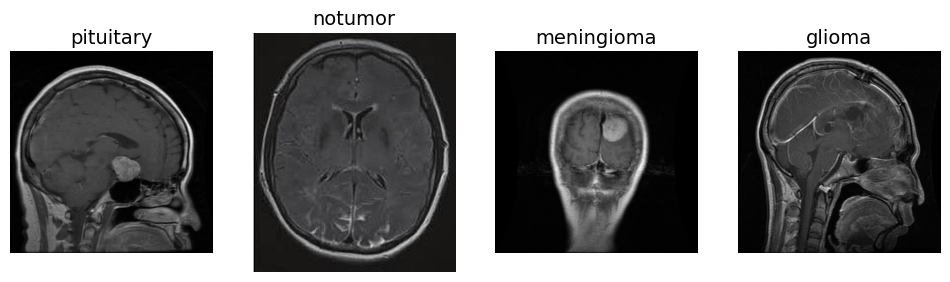

In [3]:
sample={}
for clss in classes:
    clss_path=os.path.join(data,clss)
    image_name=random.choice(os.listdir(clss_path))
    image_path=os.path.join(clss_path,image_name)
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    sample[clss]=image

plt.figure(figsize=(12,8))
for i,(clss,image) in enumerate(sample.items()):
    plt.subplot(1,len(classes),i+1)
    plt.imshow(image)
    plt.title(clss,fontsize=14)
    plt.axis("off")
plt.show()

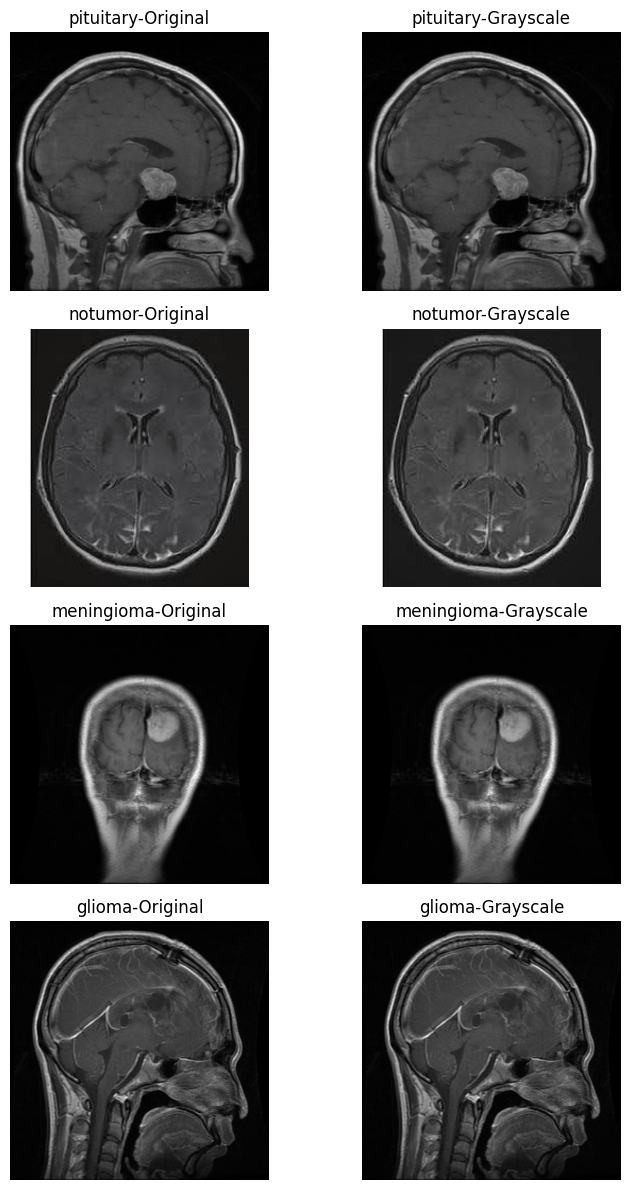

In [4]:
gray_results={}
for clss,image in sample.items():
    if image.ndim==3 and image.shape[2]==3:
        gray=rgb2gray(image)
    else:
        print("can't coverage")
    gray_results[clss]=gray
fig,axes=plt.subplots(len(classes),2,figsize=(8,12))
for i,(clss,img) in enumerate(sample.items()):
    gray=gray_results[clss]
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"{clss}-Original")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(gray,cmap="gray")
    axes[i, 1].set_title(f"{clss}-Grayscale")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()

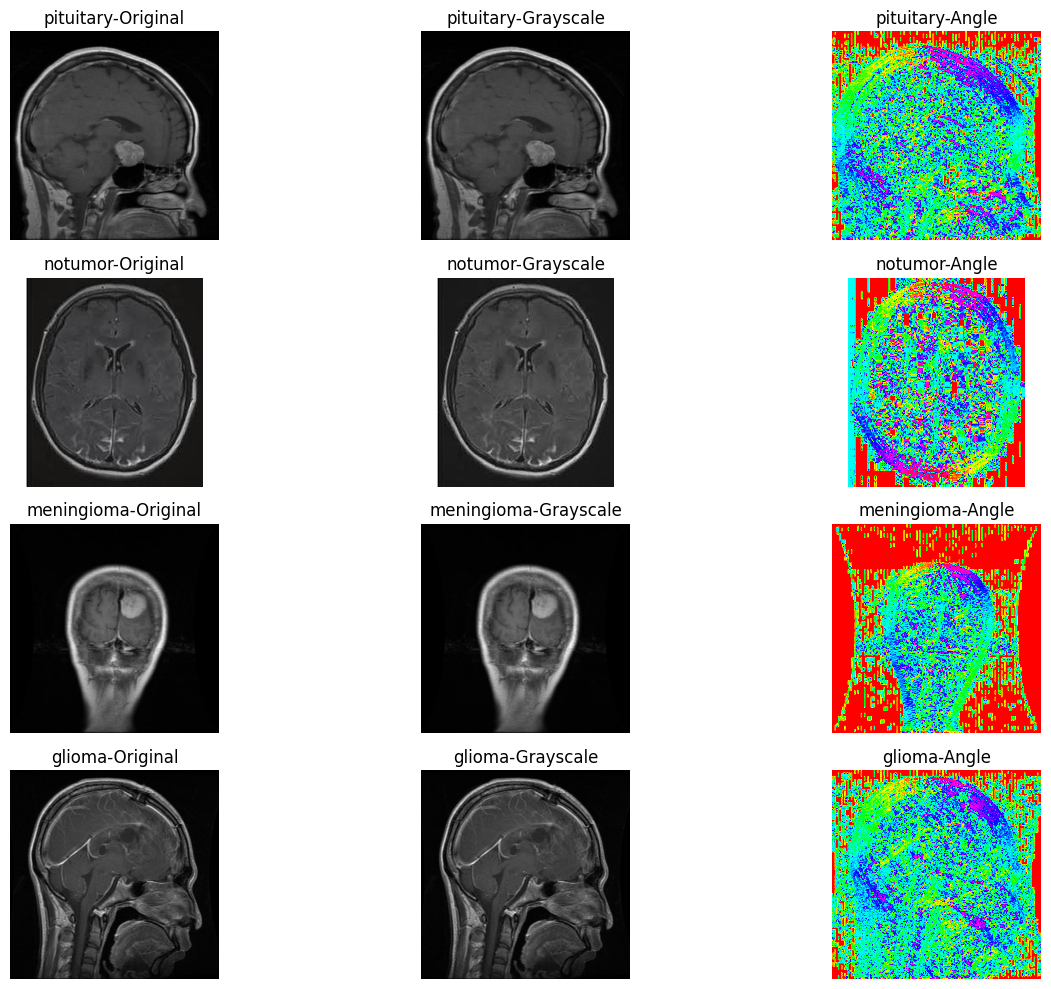

In [5]:
def angle(dx,dy):
    return np.mod(np.arctan2(dy,dx),np.pi)
angle_images={}
for clss,img in gray_results.items():
    angle_sobel=angle(filters.sobel_h(img),filters.sobel_v(img))
    angle_images[clss]=angle_sobel
fig,axes=plt.subplots(len(classes),3,figsize=(14, 10))
for i,clss in enumerate(classes):
    axes[i, 0].imshow(sample[clss])  
    axes[i, 0].set_title(f"{clss}-Original")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(gray_results[clss], cmap="gray")   
    axes[i, 1].set_title(f"{clss}-Grayscale")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(angle_images[clss], cmap="hsv")   
    axes[i, 2].set_title(f"{clss}-Angle")
    axes[i, 2].axis("off")
plt.tight_layout()
plt.show()

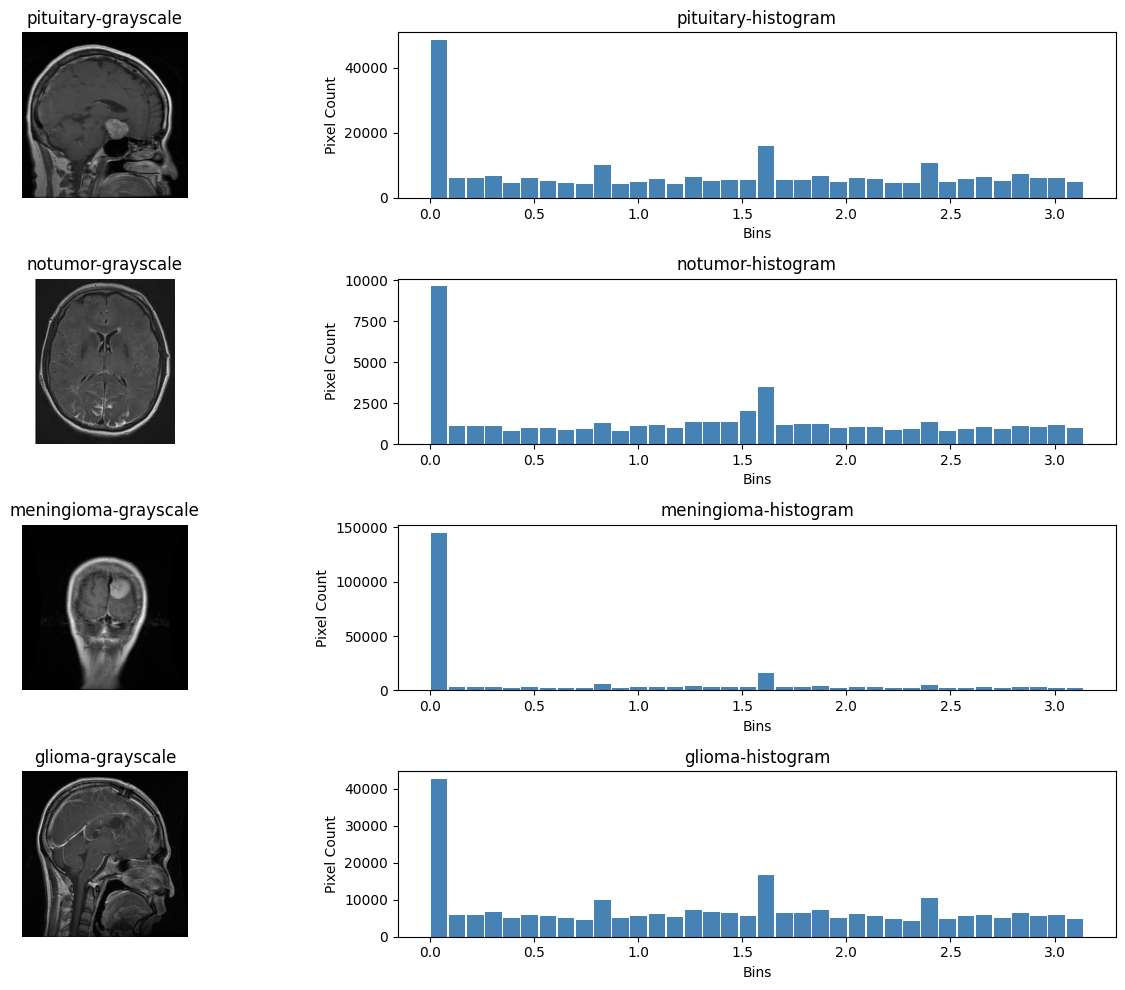

In [6]:
hist_results={}
plt.figure(figsize=(14,10))
for i,(clss,angle) in enumerate(angle_images.items()):
    hist,bin_centers=exposure.histogram(angle,nbins=36)
    hist_results[clss]=hist
    plt.subplot(len(classes),2,2*i+1)
    plt.imshow(gray_results[clss],cmap="gray")
    plt.title(f"{clss}-grayscale")
    plt.axis("off")
    plt.subplot(len(classes),2,2*i+2)
    plt.bar(bin_centers,hist,width=0.08,color="steelblue")
    plt.title(f"{clss}-histogram")
    plt.xlabel("Bins")
    plt.ylabel("Pixel Count")
plt.tight_layout()
plt.show()    

In [7]:
def compare_his(cls1,cls2):
    f1=hist_results[cls1].reshape(1,-1)
    f2=hist_results[cls2].reshape(1,-1)
    
    eudclidean=pairwise_distances(f1,f2,metric='euclidean')[0][0]
    manhattan=pairwise_distances(f1,f2,metric='manhattan')[0][0]
    cosine=pairwise_distances(f1,f2,metric='cosine')[0][0]

    print('Compare results:')
    print(f"1.Eudclidean distance:{eudclidean:.4f}")
    print(f"2.Manhattan distance:{manhattan:.4f}")
    print(f"3.Cosine distance:{cosine:.4f}")


cls1, cls2 = list(hist_results.keys())[:2]
compare_his(cls1, cls2)

Compare results:
1.Eudclidean distance:49773.6013
2.Manhattan distance:211880.0000
3.Cosine distance:0.0095


HOG feature vector length:(142884,)


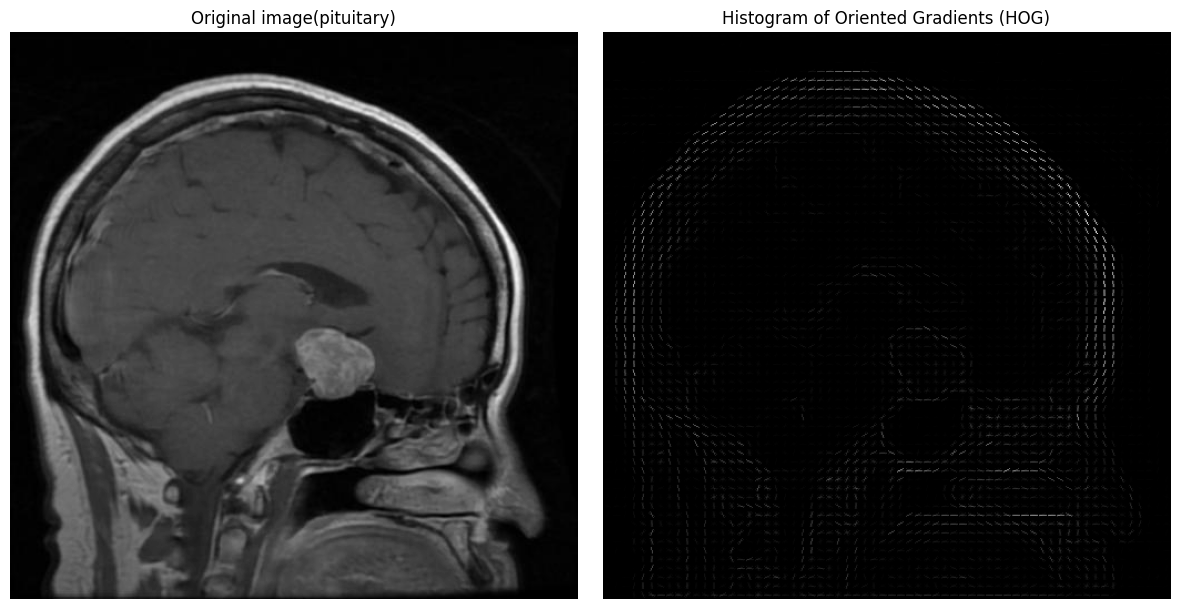

In [8]:
cls=list(gray_results.keys())[0]
image=gray_results[cls]
fd,hog_image=hog(
    image,
    orientations=9,                
    pixels_per_cell=(8, 8),        
    cells_per_block=(2, 2),        
    visualize=True,
    channel_axis=None         
)

print(f"HOG feature vector length:{fd.shape}")
hog_imag=exposure.rescale_intensity(hog_image,in_range=(0, 10))
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12, 6),sharex=True,sharey=True)
ax1.imshow(image,cmap=plt.cm.gray)
ax1.set_title(f"Original image({cls})")
ax1.axis("off")
ax2.imshow(hog_imag,cmap=plt.cm.gray)
ax2.set_title("Histogram of Oriented Gradients (HOG)")
ax2.axis("off")
plt.tight_layout()
plt.show()

# Q4 
1. Use all images from the four classes.  
2. Convert them into 36-bin edge histograms.  
3. Apply PCA (n_components=2) to project data into 2D.  
4. Visualize the results with a scatter plot, each class in a different color.  


In [9]:
def angle(dx, dy):
    return np.mod(np.arctan2(dy, dx), np.pi)

In [10]:
x=[]
y=[]
data='/kaggle/input/brain-tumor-mri-dataset/Training'
classes=os.listdir(data)
print("Classes:",classes)
print('Num of Classes:',len(classes))
plt.figure(figsize=(12,8))
for clss in classes:
    class_path=os.path.join(data, clss)
    for image_name in os.listdir(class_path):
        image_path=os.path.join(class_path,image_name)
        image=cv2.imread(image_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        gray=color.rgb2gray(image)
        angle_sobel=angle(filters.sobel_h(gray),filters.sobel_v(gray))
        hist,bin_centers=exposure.histogram(angle_sobel,nbins=36)
        x.append(hist)
        y.append(clss)
print("Matrix shape:",len(x))
print("Labels shape:",len(y))

Classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
Num of Classes: 4
Matrix shape: 5712
Labels shape: 5712


<Figure size 1200x800 with 0 Axes>

X shape: (5712, 36) labels shape: (5712,)
Reduced shape: (5712, 2)
Variance ratio: [0.91792844 0.07659   ]


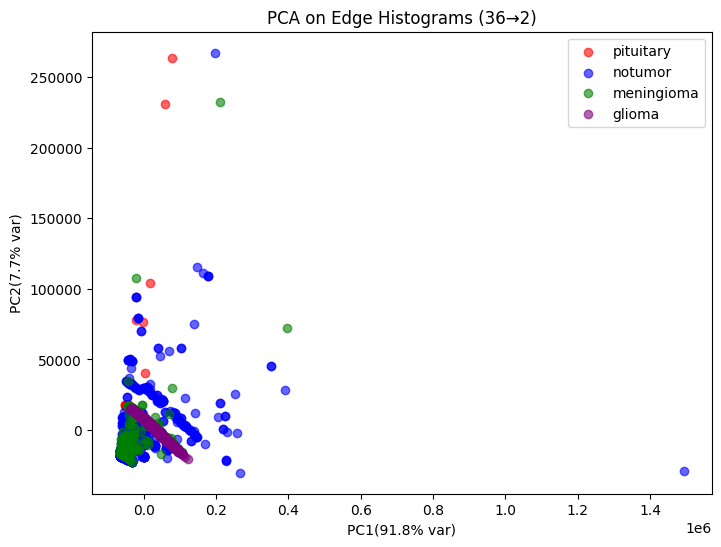

In [11]:
x=np.asarray(x, dtype=np.float64)   
y=np.asarray(y)                
print("X shape:",x.shape,"labels shape:",y.shape)
pca=PCA(n_components=2)
x_pca=pca.fit_transform(x)
print("Reduced shape:",x_pca.shape)
print("Variance ratio:",pca.explained_variance_ratio_)
plt.figure(figsize=(8,6))
colors=['red','blue','green','purple']
for i,clss in enumerate(classes):
    plt.scatter(x_pca[y==clss,0],x_pca[y==clss,1],label=clss,color=colors[i],alpha=0.6)

plt.xlabel(f"PC1({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA on Edge Histograms (36→2)")
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

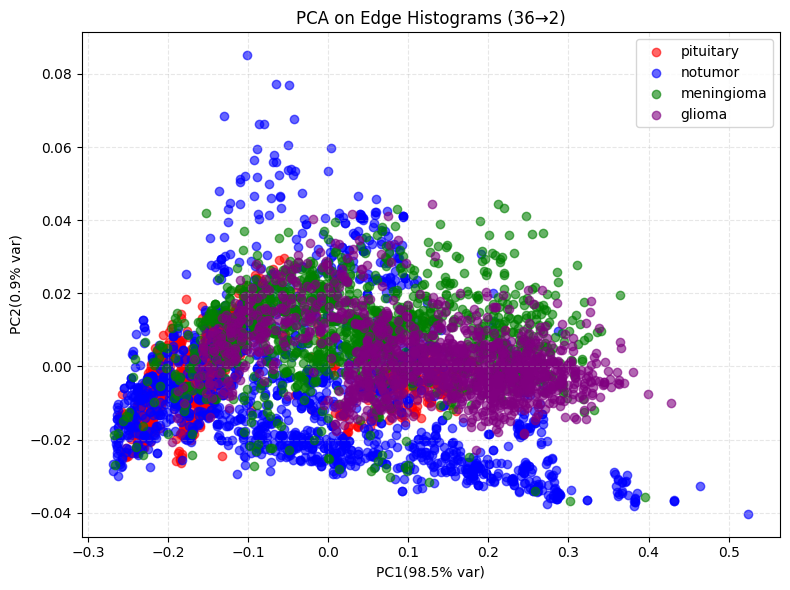

In [12]:
x_norm=normalize(x,norm='l1')
pca=PCA(n_components=2,random_state=0)
z=pca.fit_transform(x_norm)
plt.figure(figsize=(8,6))
colors=['red','blue','green','purple']
plt.figure(figsize=(8,6))
for i,clss in enumerate(classes):
    m=(y==clss)
    plt.scatter(z[m,0],z[m,1],label=clss,color=colors[i],alpha=0.6)

plt.xlabel(f"PC1({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA on Edge Histograms (36→2)")
plt.legend(frameon=True)
plt.grid(True,ls='--',alpha=0.3)
plt.tight_layout()
plt.show()

## How many classes are visually separable (i.e., non-overlapping) 
### Answer: 0 classes

# Q5

In [20]:
train_json="/kaggle/input/student-5/train.json"
emo_classes=['anger','anticipation','disgust','fear','joy','love','optimism','pessimism','sadness','surprise','trust']

In [21]:
df=pd.read_json(train_json,lines=True)
df.head(10)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-30344,Live simply. Dream big. Be grateful. Give love...,False,False,False,False,True,False,True,False,False,False,True
1,2017-En-31519,Come to the @BullSkitComedy FUNdraiser this Fr...,False,False,False,False,False,False,False,False,False,False,False
2,2017-En-41145,@bldmovs sadly beautiful photo.,False,False,False,False,True,True,True,False,True,False,False
3,2017-En-30651,"@eachus At least he's willing to discuss, bett...",False,False,False,False,False,False,True,True,False,False,False
4,2017-En-30133,@PriiiincesssE thanks for distracting me from ...,False,False,False,False,True,True,True,False,False,False,False
5,2017-En-41070,The @Orioles are in contention and hosting @Re...,False,False,False,False,False,False,False,True,True,False,False
6,2017-En-11037,I wanna kill you and destroy you. I want you d...,True,False,True,False,False,False,False,False,False,False,False
7,2017-En-41465,@pete_ferriday Aww rest your weary head here,False,False,False,False,True,False,True,False,False,False,True
8,2017-En-30718,I saw those dreams dashed &amp;&amp; divided l...,False,False,False,False,False,False,False,False,True,False,False
9,2017-En-40090,Baaarissshhhhh + sad song = prefect night — f...,False,False,False,False,False,False,False,True,True,False,False


In [22]:
print("Columns:",list(df.columns))

Columns: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']


In [23]:
target="Tweet"
label_cards=df.drop(columns=[m for m in ["ID",target] if m in df.columns],errors="ignore").copy()
for c in label_cards.columns:
    vals=label_cards[c].astype(str).str.lower()
    if set(vals.unique())<={"true","false"}:
        label_cards[c]=vals.map({"true":True,"false":False})
label_c=label_cards.select_dtypes(include=["bool"]).columns.tolist()
true_counts=df[label_c].sum(axis=1)
df1=df[true_counts==1].copy()
df1["label"]=df1[label_c].idxmax(axis=1)
print("Kept rows:",len(df1),"/",len(df))
print(df1["label"].value_counts().sort_index())

Kept rows: 409 / 3000
label
anger            45
anticipation     25
disgust          22
fear             74
joy             118
love              1
optimism         42
pessimism         4
sadness          73
surprise          5
Name: count, dtype: int64


In [24]:
all_true=df[label_c].sum(axis=1)
print("0-label rows:",(all_true==0).sum())
print(">=2-label rows:",(all_true>=2).sum())
print("==1-label rows:",(all_true==1).sum())

0-label rows: 87
>=2-label rows: 2504
==1-label rows: 409


In [26]:
texts=df1[target].astype(str).tolist()
labels=df1["label"].astype(str).to_numpy()
cv=CountVectorizer()
tfv=TfidfVectorizer()
x_count=cv.fit_transform(texts)   
x_tfidf=tfv.fit_transform(texts) 
v_count=len(cv.get_feature_names_out())
v_tfidf=len(tfv.get_feature_names_out())
print("CountVectorizer shape:",x_count.shape,"-> |V_count|:",v_count)
print("TfidfVectorizer shape:",x_tfidf.shape,"-> |V_tfidf|:",v_tfidf)

CountVectorizer shape: (409, 2301) -> |V_count|: 2301
TfidfVectorizer shape: (409, 2301) -> |V_tfidf|: 2301


In [27]:
selected=['joy','sadness','fear','anger'] 
mask=np.isin(labels,selected)
x_count,x_tfidf,yc=x_count[mask],x_tfidf[mask],labels[mask]
print("Subset sizes:",x_count.shape,x_tfidf.shape,yc.shape)
per=Counter(yc)
min_c=min(per[m] for m in selected)
rn=np.random.default_rng(0)
idx_b=np.hstack([rn.choice(np.where(yc==c)[0],size=min_c,replace=False) for c in selected])
idx_b.sort()
x_count,x_tfidf,yc=x_count[idx_b],x_tfidf[idx_b],yc[idx_b]
print("Balanced per-class:",min_c,"| total:",x_count.shape[0])

Subset sizes: (310, 2301) (310, 2301) (310,)
Balanced per-class: 45 | total: 180


(counts)2D explained variance: 0.0826
(tfidf)2D explained variance: 0.0267


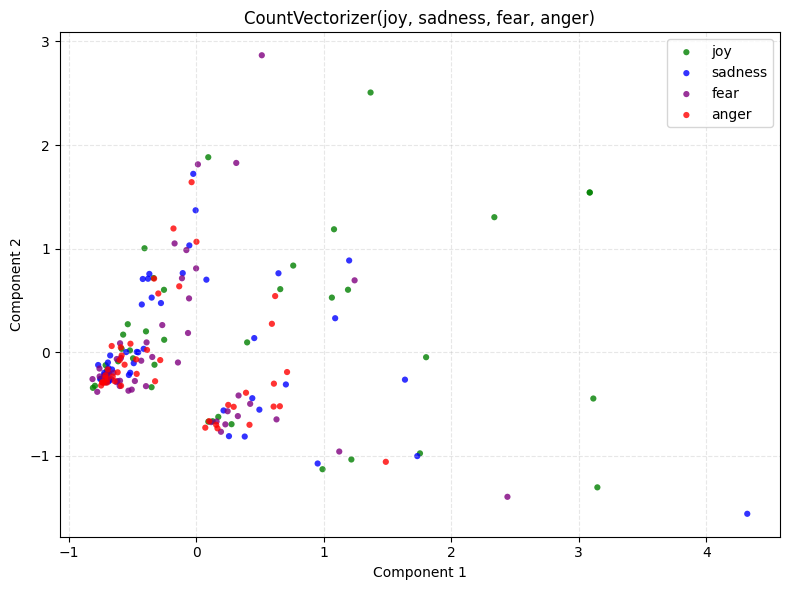

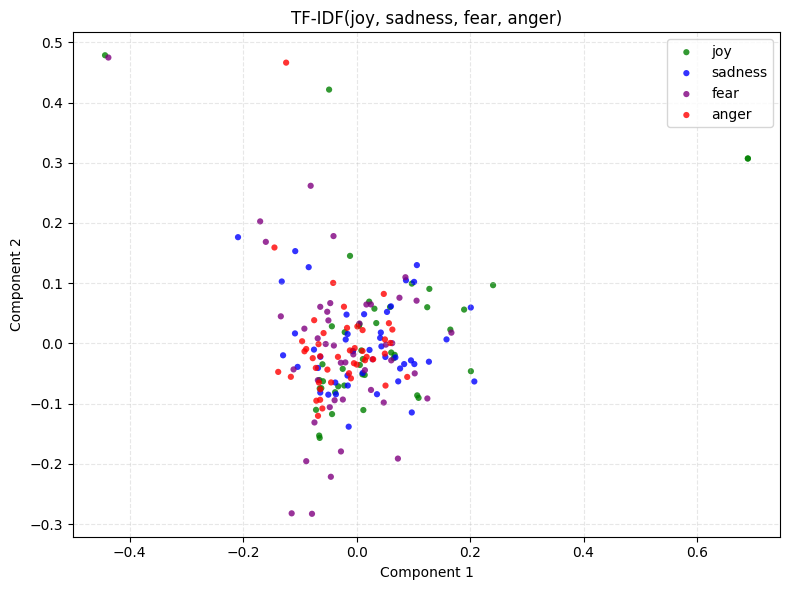

In [28]:
def reduce_to(x_sparse):
        x_dense=x_sparse.toarray()
        pca=PCA(n_components=2, random_state=0)
        z=pca.fit_transform(x_dense)
        return z,pca.explained_variance_ratio_.sum()
z_counts,counts=reduce_to(x_count)
z_tfidf,vtfidf=reduce_to(x_tfidf)

print(f"(counts)2D explained variance: {counts:.4f}")
print(f"(tfidf)2D explained variance: {vtfidf:.4f}")

palette={'joy':'green','sadness':'blue','fear':'purple','anger':'red'}

def plotD(z,y,title):
    plt.figure(figsize=(8,6))
    for c in selected:
        m=(y==c)
        plt.scatter(z[m,0],z[m,1],s=20,alpha=0.8,label=c,color=palette.get(c,'gray'),edgecolors='none')
    plt.xlabel("Component 1"); 
    plt.ylabel("Component 2")
    plt.title(title); 
    plt.legend(frameon=True)
    plt.grid(True, ls='--', alpha=0.3); 
    plt.tight_layout(); 
    plt.show()

plotD(z_counts,yc,f"CountVectorizer({', '.join(selected)})")
plotD(z_tfidf,yc,f"TF-IDF({', '.join(selected)})")

## Which classes (if any) are visually separable (i.e., non-overlapping) for both plots? (0.5 point)
## Answer: None                                                                                                                                                          

### 1. In the first figure(title: CountVectorizer), there are a small number of outliers and minor clusters for joy and sadness on the right-hand side, though these partially overlap with samples from fear(purple) and anger(red). The left region shows significant overlap among all four categories.                                    
### 2. In the second figure(title: TF-IDF), the point cloud clusters are almost entirely concentrated near the origin, forming a high-density mass with only a few outliers. The four categories exhibit overall overlap and can't be distinguished completely. 
          
### 3. In summary, while individual outliers for joy/sadness deviate considerably in the Count plot, they still overlap with other categories in the TF-IDF plot. 
             .

In [34]:
from kaggle_secrets import UserSecretsClient
import os

user_secrets = UserSecretsClient()
os.environ["GITHUB_TOKEN"] = user_secrets.get_secret("GITHUB_TOKEN")

print("✅ Kaggle Secret 已成功写入环境变量！")

✅ Kaggle Secret 已成功写入环境变量！


In [35]:
%%bash
set -euo pipefail

# ======== 你的信息（改成你自己的）========
USER="z1zw"
EMAIL="1632038464@qq.com"
REPO="Data-Mining-Programming"
# ===========================================

# Kaggle 会自动注入 GITHUB_TOKEN（来自 Secrets）
: "${GITHUB_TOKEN:?ERROR: Please add a Kaggle Secret named GITHUB_TOKEN}"

WORK="/kaggle/working/${REPO}"
mkdir -p "$WORK"

echo "==> 初始化 git 仓库..."
cd "$WORK"
git init
git config user.name  "$USER"
git config user.email "$EMAIL"

echo "==> 拷贝 Notebook, 代码和数据..."
mkdir -p notebooks src data figures
cp -v /kaggle/working/*.ipynb notebooks/ || true
cp -v /kaggle/working/*.py    src/       || true
cp -R /kaggle/input/brain-tumor-mri-dataset data/brain-tumor-mri-dataset || true
cp -R /kaggle/input/student-5 data/student-5 || true

echo "==> 创建 README.md ..."
cat > README.md <<'EOF'
# Data-Mining-Programming

> Brain MRI edge histograms & HOG · Tweet Count/TF-IDF · PCA(→2D) · Visual separability analysis

[![Stars](https://img.shields.io/github/stars/z1zw/Data-Mining-Programming?style=flat-square)](https://github.com/z1zw/Data-Mining-Programming/stargazers)
[![Forks](https://img.shields.io/github/forks/z1zw/Data-Mining-Programming?style=flat-square)](https://github.com/z1zw/Data-Mining-Programming/network/members)
[![Issues](https://img.shields.io/github/issues/z1zw/Data-Mining-Programming?style=flat-square)](https://github.com/z1zw/Data-Mining-Programming/issues)
[![License](https://img.shields.io/badge/license-MIT-green.svg?style=flat-square)](LICENSE)

## 📖 Overview
- **Images**: RGB→Grayscale → Sobel edges → 36-bin histograms → PCA(36→2D)
- **HOG Features**: Extracted via `skimage.feature.hog`
- **Tweets**: CountVectorizer / TF-IDF → PCA(2D) visualization
- **Conclusion**: No perfectly separable clusters, strong overlaps between classes.

## 🚀 Usage
```bash
pip install -r requirements.txt

==> 初始化 git 仓库...
Initialized empty Git repository in /kaggle/working/Data-Mining-Programming/.git/
==> 拷贝 Notebook, 代码和数据...
==> 创建 README.md ...


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
cp: cannot stat '/kaggle/working/*.ipynb': No such file or directory
cp: cannot stat '/kaggle/working/*.py': No such file or directory
bash: line 47: warning: here-document at line 29 delimited by end-of-file (wanted `EOF')
